In [3]:
import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np
import os
import importlib.util
import huggingface_hub

In [6]:
from vit_prisma.sae.sae import SparseAutoencoder
from vit_prisma.sae.evals.evals import EvalConfig

from huggingface_hub import hf_hub_download

def download_sae_from_huggingface(repo_name, file_id, download_dir):
    os.makedirs(download_dir, exist_ok=True)
    local_path = hf_hub_download(repo_id=repo_name, filename=file_id, local_dir=download_dir)
    print(f"File downloaded successfully to: {local_path}")
    print(f"File size: {os.path.getsize(local_path)} bytes")
    

def download_sae():
    repo_name = 'Prisma-Multimodal/sae_weights'
    file_id = 'UPDATED-final_sae_group_wkcn_TinyCLIP-ViT-40M-32-Text-19M-LAION400M_blocks.9.hook_mlp_out_8192.pt'
    download_dir = '/network/scratch/s/sonia.joseph/sae_checkpoints/tinyclip_40M_mlp_out/mustache_sae_16_mlp_out'
    download_sae_from_huggingface(repo_name, file_id, download_dir)

def load_sae():
    sae_path = '/network/scratch/s/sonia.joseph/sae_checkpoints/tinyclip_40M_mlp_out/mustache_sae_16_mlp_out/UPDATED-final_sae_group_wkcn_TinyCLIP-ViT-40M-32-Text-19M-LAION400M_blocks.9.hook_mlp_out_8192.pt'
    cfg = EvalConfig()
    sae = SparseAutoencoder(cfg).load_from_pretrained_legacy_saelens_v2(sae_path)
    return sae

## only run this once
download_sae() 

sae = load_sae()
cfg = sae.cfg

File downloaded successfully to: /network/scratch/s/sonia.joseph/sae_checkpoints/tinyclip_40M_mlp_out/mustache_sae_16_mlp_out/UPDATED-final_sae_group_wkcn_TinyCLIP-ViT-40M-32-Text-19M-LAION400M_blocks.9.hook_mlp_out_8192.pt
File size: 33592403 bytes
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 15869
Total training images: 1300000
Total wandb updates: 158
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 15 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.0512
Lower bound: n_contexts_per_buffer (millions): 0.001024
Total training steps: 15869
Total training images: 1300000
Total wandb upd

Image downloaded successfully.
Image size: (600, 460)
Image format: JPEG


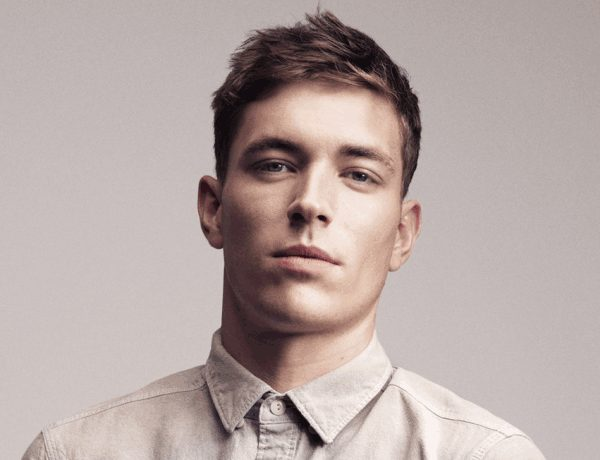

In [7]:
import requests
from PIL import Image
from io import BytesIO
def download_image_to_variable(url):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        print(f"Image downloaded successfully.")
        print(f"Image size: {image.size}")
        print(f"Image format: {image.format}")
        return image
    else:
        print(f"Failed to download image. Status code: {response.status_code}")
        return None

# Usage --> put your image here
url = "https://i0.wp.com/www.beard.org.in/wp-content/uploads/2016/11/10-Hairstyles-For-The-Clean-Shaven-Look-1-1.jpg?fit=600%2C460&ssl=1"
img = download_image_to_variable(url)
img


In [8]:
# get TinyCLIP embedding
from vit_prisma.models.base_vit import HookedViT
from vit_prisma.sae.evals.train_tinyclip_kadinsky_adapter import EmbeddingAdapter

def load_pretrained_adapter(checkpoint_path, input_dim=512, hidden_dim=2048, output_dim=1280):
    # Initialize the adapter model
    adapter = EmbeddingAdapter(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    
    # Load the state dict
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    # Load the state dict into the model
    adapter.load_state_dict(state_dict)
    
    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    adapter = adapter.to(device)
    
    # Set the model to evaluation mode
    adapter.eval()
    
    return adapter

model_name = 'wkcn/TinyCLIP-ViT-40M-32-Text-19M-LAION400M'

model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to('cuda')

adapter_path = '/network/scratch/s/sonia.joseph/diffusion/tinyclip_adapter/ntilw/adapter_checkpoint_5000.pth'
adapter = load_pretrained_adapter(adapter_path)

Official model name wkcn/TinyCLIP-ViT-40M-32-Text-19M-LAION400M
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model wkcn/TinyCLIP-ViT-40M-32-Text-19M-LAION400M into HookedTransformer


In [9]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip

data_transform = get_imagenet_transforms_clip(cfg.model_name, cfg.image_size)
transformed_img = data_transform(img).to(cfg.device)


In [10]:
from transformers import PreTrainedModel, PretrainedConfig


class SimpleConfig(PretrainedConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

class AdaptedModel(PreTrainedModel):
    base_model_prefix = "adapted_model"

    def __init__(self, config, original_model, adapter):
        super(AdaptedModel, self).__init__(config)
        self.original_model = original_model
        self.adapter = adapter

    def forward(self, x):
        # Ensure input is unsqueezed if necessary
        if x.dim() == 3:
            x = x.unsqueeze(0)

        # Pass through the original model
        output_embed = self.original_model(x)

        # Pass through the adapter
        adapted_embeds = self.adapter(output_embed)

        adapted_output = {}
        adapted_output["image_embeds"] = adapted_embeds

    
        return adapted_output

# Usage

# Usage


In [11]:
from diffusers import StableUnCLIPImg2ImgPipeline
import torch

cache_dir = '/network/scratch/s/sonia.joseph/diffusion'
model_id = "stabilityai/stable-diffusion-2-1-unclip"
cache_dir = '/network/scratch/s/sonia.joseph/diffusion'




/home/mila/s/sonia.joseph/env/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.



In [12]:
import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np
import os
import importlib.util
import huggingface_hub


torch.set_grad_enabled(False)
torch.manual_seed(42)

DEVICE = torch.device('cuda:0')

def load_kadinsky():
    encoder = CLIPVisionModelWithProjection.from_pretrained(
        'kandinsky-community/kandinsky-2-2-prior',
        subfolder='image_encoder'
    ).half().to(DEVICE)

    adapted_tinyclip = AdaptedModel(config=encoder.config, original_model=model, adapter=adapter).to(DEVICE)

    unet = UNet2DConditionModel.from_pretrained(
        'kandinsky-community/kandinsky-2-2-decoder',
        subfolder='unet'
    ).half().to(DEVICE)

    prior = KandinskyV22PriorPipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-2-prior',
        image_encoder=encoder,
        torch_dtype=torch.float16
    ).to(DEVICE)

    adapted_prior = KandinskyV22PriorPipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-2-prior',
        image_encoder=adapted_tinyclip,
        torch_dtype=torch.float16
    ).to(DEVICE)

    decoder = KandinskyV22Pipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-2-decoder',
        unet=unet,
        torch_dtype=torch.float16
    ).to(DEVICE)

    zero_embed = prior.get_zero_embed()

    return encoder, prior, adapted_prior, decoder, zero_embed, adapted_tinyclip

In [13]:
def embed_image(item, prior):
    return prior.interpolate([item], [1]).image_embeds[0]


def generate_one(image_embeds):
    generator = torch.Generator("cuda")
    generator.manual_seed(1)
    images = decoder(
        image_embeds=image_embeds.unsqueeze(0),
        negative_image_embeds=negative_emb,
        height=512,
        width=512,
        num_inference_steps=18,
        num_images_per_prompt=1,
        generator=generator,
    ).images

    return images[0]


In [14]:
encoder, prior, adapted_prior, decoder, negative_emb, adapted_tinyclip = load_kadinsky()



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1280])


  0%|          | 0/18 [00:00<?, ?it/s]

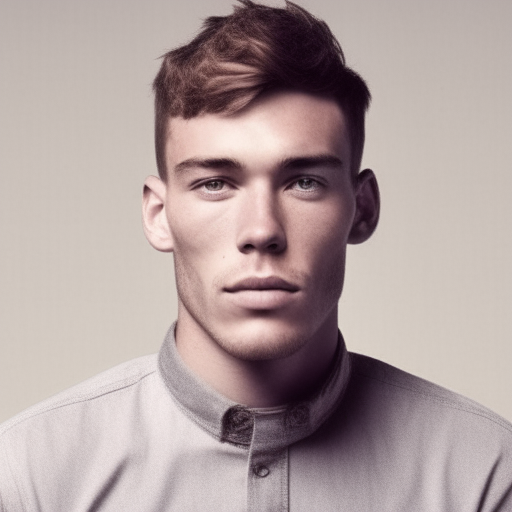

In [15]:
og_embedding = embed_image(img, prior)
print(og_embedding.shape)

generated_image = generate_one(og_embedding)

generated_image


In [16]:
output_of_adapted_encoder = adapted_tinyclip(transformed_img.unsqueeze(0))
print(output_of_adapted_encoder['image_embeds'].shape)

torch.Size([1, 1280])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

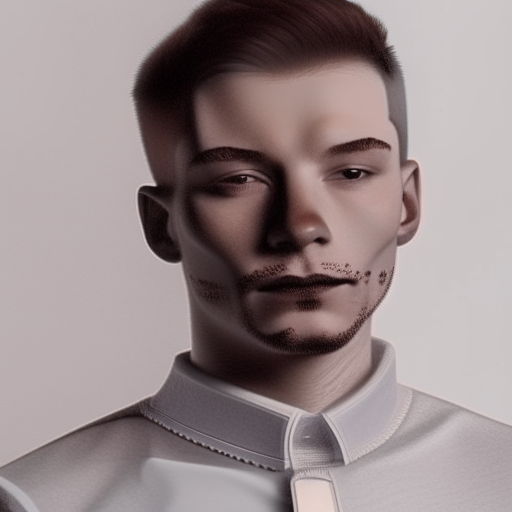

In [17]:
adapted_embedding = embed_image(img, adapted_prior)
generated_image = generate_one(adapted_embedding)
generated_image




Woohoo! It kind of works!!

In [18]:
# Load library of logit labels
!wget https://raw.githubusercontent.com/yossigandelsman/clip_text_span/main/text_descriptions/image_descriptions_general.txt
all_labels = [line.strip() for line in open("image_descriptions_general.txt").readlines()]
print(len(all_labels))
print(all_labels[:5])

all_labels.append("mustache")
all_labels.append("man with mustache")
import torch
from transformers import CLIPModel, CLIPProcessor

device = 'cuda'

def get_text_embeddings(model_name, original_text, batch_size=32):
    vanilla_model = CLIPModel.from_pretrained(model_name).to(device)
    processor = CLIPProcessor.from_pretrained(model_name, do_rescale=False)

    # Split the text into batches
    text_batches = [original_text[i:i+batch_size] for i in range(0, len(original_text), batch_size)]

    all_embeddings = []

    for batch in text_batches:
        inputs = processor(text=batch, return_tensors='pt', padding=True, truncation=True, max_length=77)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            text_embeddings = vanilla_model.get_text_features(**inputs)

        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
        all_embeddings.append(text_embeddings)

    # Concatenate all batches
    final_embeddings = torch.cat(all_embeddings, dim=0)

    del vanilla_model, processor
    torch.cuda.empty_cache()

    return final_embeddings



--2024-09-20 13:54:19--  https://raw.githubusercontent.com/yossigandelsman/clip_text_span/main/text_descriptions/image_descriptions_general.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88419 (86K) [text/plain]
Saving to: ‘image_descriptions_general.txt’

image_descriptions_ 100%[===================>]  86.35K  --.-KB/s    in 0.002s  

2024-09-20 13:54:20 (43.4 MB/s) - ‘image_descriptions_general.txt’ saved [88419/88419]

3498
['A badge', 'A bag', 'A ball', 'A bamboo', 'Abandoned factory space']


In [19]:
# Usage
model_name = 'wkcn/TinyCLIP-ViT-40M-32-Text-19M-LAION400M'
text_embeddings = get_text_embeddings(model_name, all_labels)


In [20]:
def get_similarity(image_features, text_features, k=5):
  image_features = image_features.to(device)
  text_features = text_features.to(device)

  similarity = (image_features @ text_features.T).softmax(dim=-1)
  softmax_values, top_k_indices = torch.topk(similarity, k, dim=-1)
  return softmax_values, top_k_indices, similarity


In [23]:
softmax_values, top_k_indices, total_similarity = get_similarity(adapted_embedding, text_embeddings, k=5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1280 and 512x3500)

In [ ]:
for value, indices in zip(softmax_values, top_k_indices.detach()):
    for v, i in zip(value,indices):
        print(v.detach().cpu(), all_labels[i])
    print()

tensor(0.0006) An image of a Actor
tensor(0.0006) A photo of a man
tensor(0.0006) A photo of a young person
tensor(0.0006) A photo of a teenager
tensor(0.0005) Serious facial expression



In [24]:
total_similarity[0]
# plot histogram of logit values
import matplotlib.pyplot as plt
plt.hist(total_similarity[0].cpu().detach().numpy(), bins=100)
plt.title("logit values")
print("Average logit value: ", total_similarity[0].mean().item())

print("Value of mustache logit", total_similarity[0][all_labels.index("mustache")].item())

NameError: name 'total_similarity' is not defined

In [ ]:
for name, param in sae.named_parameters():
    print(name, param.shape)

sae.W_enc

W_dec torch.Size([8192, 512])
W_enc torch.Size([512, 8192])
b_enc torch.Size([8192])
b_dec torch.Size([512])


Parameter containing:
tensor([[ 0.0136,  0.0173,  0.0195,  ..., -0.0300, -0.0062,  0.0172],
        [ 0.0025, -0.0378, -0.0209,  ..., -0.0152,  0.0419,  0.0283],
        [-0.0085, -0.0222,  0.0861,  ..., -0.1196, -0.0129, -0.0026],
        ...,
        [-0.0017, -0.0110, -0.0096,  ...,  0.1168,  0.0266,  0.0257],
        [ 0.0228,  0.0045, -0.0059,  ...,  0.0739,  0.0136,  0.0021],
        [-0.0050, -0.0014, -0.0518,  ...,  0.0122, -0.0028,  0.0282]],
       device='cuda:0', requires_grad=True)

In [25]:
# Inject the SAE feature

# import ANY
from typing import Any
from functools import partial

import einops

# Inject feature 2381




def clamp_replacement_hook(activations: torch.Tensor, hook: Any):
    b, seq_len, _ = activations.shape
    post_reshaped = einops.rearrange(activations, "batch seq d_mlp -> (batch seq) d_mlp")

    sae_in = post_reshaped - sae.b_dec
    acts = einops.einsum(
        sae_in,
        sae.W_enc,
        "... d_in, d_in n -> ... n",
    )
    acts = acts + sae.b_enc
    acts = torch.nn.functional.relu(acts)

    # Reshape acts to (batch, seq, n_features)
    acts_reshaped = einops.rearrange(acts, "(batch seq) n_features -> batch seq n_features", batch=b, seq=seq_len)


    print("clamped value before", acts_reshaped[:,:,feature_to_clamp])
    acts_reshaped[:,:,feature_to_clamp] = new_clamp_value
    print("clamped value after", acts_reshaped[:,:,feature_to_clamp])

    activations = acts_reshaped @ sae.W_dec
    return activations


feature_to_clamp = 2381
new_clamp_value = 4.5
new_clamp_value = -1000


hook_point = 'blocks.9.hook_mlp_out'
modified_output_embed = model.run_with_hooks(
        transformed_img.unsqueeze(0),
        fwd_hooks=[(hook_point, partial(clamp_replacement_hook))],
)




clamped value before tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], device='cuda:0')
clamped value after tensor([[-1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
         -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
         -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
         -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
         -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
         -1000., -1000., -1000., -1000., -1000.]], device='cuda:0')


In [50]:

import torch
import torch.nn as nn
import einops
from typing import Any
from functools import partial

class AdaptedCLIPVisionModelWithProjection(PreTrainedModel):
    def __init__(self, original_model, config, adapter, sae, feature_to_clamp, new_clamp_value):
        super(AdaptedCLIPVisionModelWithProjection, self).__init__(config)
        self.original_model = original_model
        self.adapter = adapter
        self.config = config
        # self.dtype = model.cfg.dtype
        # self.device = model.cfg.device
        
        # SAE and clamping parameters
        self.sae = sae
        self.feature_to_clamp = feature_to_clamp
        self.new_clamp_value = new_clamp_value

    def clamp_replacement_hook(self, activations: torch.Tensor, hook: Any):
        b, seq_len, _ = activations.shape
        post_reshaped = einops.rearrange(activations, "batch seq d_mlp -> (batch seq) d_mlp")

        sae_in = post_reshaped - self.sae.b_dec
        acts = einops.einsum(
            sae_in,
            self.sae.W_enc,
            "... d_in, d_in n -> ... n",
        )
        acts = acts + self.sae.b_enc
        acts = torch.nn.functional.relu(acts)

        acts_reshaped = einops.rearrange(acts, "(batch seq) n_features -> batch seq n_features", batch=b, seq=seq_len)

        print("clamped value before", acts_reshaped[:,:,self.feature_to_clamp])
        acts_reshaped[:,:,self.feature_to_clamp] = self.new_clamp_value
        print("clamped value after", acts_reshaped[:,:,self.feature_to_clamp])

        activations = acts_reshaped @ self.sae.W_dec
        return activations

    def forward(self, pixel_values, output_attentions=None, output_hidden_states=None, return_dict=None):
        # Apply the clamping hook
        hook_point = 'blocks.9.hook_mlp_out'
        fwd_hooks = [(hook_point, partial(self.clamp_replacement_hook))]
        

        # Pass through the original model
        output_embed = self.original_model.run_with_hooks(
        pixel_values,
        fwd_hooks=[(hook_point, partial(clamp_replacement_hook))]
    )


        # Pass through the adapter
        adapted_embeds = self.adapter(output_embed)

        adapted_output = {}
        adapted_output["image_embeds"] = adapted_embeds

        return adapted_output

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
feature_to_clamp = 2381
new_clamp_value = 1000

config = encoder.config
# Create the adapted image encoder
adapted_image_encoder = AdaptedCLIPVisionModelWithProjection(
    model, 
    config,
    adapter, 
    sae, 
    feature_to_clamp, 
    new_clamp_value
)

# create new adapted prior



clamped value before tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], device='cuda:0')
clamped value after tensor([[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]],
       device='cuda:0')


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

clamped value before tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], device='cuda:0')
clamped value after tensor([[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]],
       device='cuda:0')


  0%|          | 0/25 [00:00<?, ?it/s]

clamped value before tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], device='cuda:0')
clamped value after tensor([[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]],
       device='cuda:0')


  0%|          | 0/18 [00:00<?, ?it/s]

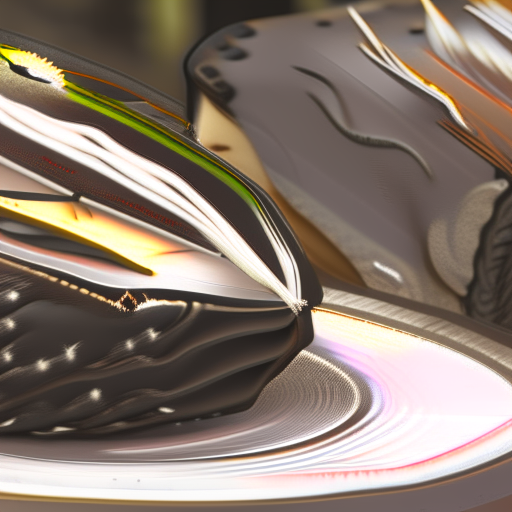

In [51]:
output_embedding = adapted_image_encoder(transformed_img.unsqueeze(0))

clamped_adapted_prior = KandinskyV22PriorPipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-2-prior',
        image_encoder=adapted_image_encoder,
        torch_dtype=torch.float16
    ).to(DEVICE)

# generate
adapted_embedding = embed_image(img, clamped_adapted_prior)
generated_image = generate_one(adapted_embedding)
generated_image

In [ ]:
softmax_values, top_k_indices, total_similarity = get_similarity(output_embed, text_embeddings, k=5)
for value, indices in zip(softmax_values, top_k_indices.detach()):
    for v, i in zip(value,indices):
        print(v.detach().cpu(), all_labels[i])
print("Value of mustache logit", total_similarity[0][all_labels.index("mustache")].item())

print()

softmax_values, top_k_indices, total_similarity = get_similarity(modified_output_embed, text_embeddings, k=5)
for value, indices in zip(softmax_values, top_k_indices.detach()):
    for v, i in zip(value,indices):
        print(v.detach().cpu(), all_labels[i])
print("Value of mustache logit", total_similarity[0][all_labels.index("mustache")].item())

tensor(0.0006) An image of a Actor
tensor(0.0006) A photo of a man
tensor(0.0006) A photo of a young person
tensor(0.0006) A photo of a teenager
tensor(0.0005) Serious facial expression
Value of mustache logit 0.0003400504356250167

tensor(0.0011) mustache
tensor(0.0009) man with mustache
tensor(0.0007) A leg
tensor(0.0006) Nose
tensor(0.0006) A beautiful photo
Value of mustache logit 0.0010604910785332322


# You can change the logit but it's not in the direction you'd expect.
# Making the logit very negative changes the prediction, while very positive does not.

# I'm wondering if we need some clean method of generation.

In [ ]:
# Ok, let's map TinyCLIP features to larger CLIP features
# Let's just try it